In [25]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [26]:
import geopandas as gpd
import numpy as np
from sdm.geo import generate_model_raster
import xarray as xr
import rioxarray as rxr
from scipy.ndimage import gaussian_filter
from shapely.geometry import box
from matplotlib import pyplot as plt

In [27]:
## Config
n_background_points = 10_000
background_p = 0.05 # The probability of generating points across the entire raster

In [28]:
bats = gpd.read_parquet('data/processed/sybg-bats.parquet')
bats = bats.to_crs('EPSG:27700')
bats.head()

,date,grid_reference,species_raw,activity_type,source_data,latin_name,common_name,genus,x,y,accuracy,geometry,grid_square_geom
0,2010-05-17 00:00:00,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,100.0,POINT (411550.000 508450.000),"POLYGON ((411600.000 508400.000, 411600.000 50..."
1,2014-07-03 00:00:00,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,10.0,POINT (414645.000 500215.000),"POLYGON ((414650.000 500210.000, 414650.000 50..."
2,2013-11-28 00:00:00,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,10.0,POINT (420295.000 511065.000),"POLYGON ((420300.000 511060.000, 420300.000 51..."
3,2010-08-31 00:00:00,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",Unknown,Unidentified Bat,Unknown,417050.0,501450.0,100.0,POINT (417050.000 501450.000),"POLYGON ((417100.000 501400.000, 417100.000 50..."
4,2009-05-20 00:00:00,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",Unknown,Unidentified Bat,Unknown,418550.0,511650.0,100.0,POINT (418550.000 511650.000),"POLYGON ((418600.000 511600.000, 418600.000 51..."


# Generate the Grid

In [29]:
grid = generate_model_raster()

bounds = grid.rio.bounds()
grid_x = grid.coords["x"].values
grid_y = grid.coords["y"].values
# Reverse the y axis so that it is monotonic increasing
grid_y = grid_y[::-1]

# Get the resolution of the grid
resolution_x = grid_x[1] - grid_x[0]
resolution_y = (grid_y[1] - grid_y[0]) * -1

bbox_poly = box(*bounds)
bounds

(403864.8451071749, 370493.5150017793, 483119.2583367733, 426846.1923216653)

In [30]:
# Drop bats outside the bbox
bats = bats[bats.intersects(bbox_poly)]

Calculate a 2d histogram and apply some smoothing. This counts the number of records of all species in each grid cell. The smoothing just smooths the counts a little and this allows us to generate points around the bat records not just in the same cells.

In [31]:
point_counts, bin_x, bin_y  = np.histogram2d(bats.geometry.x, bats.geometry.y, bins=(grid_x, grid_y))
# Apply some smoothing
point_counts = gaussian_filter(point_counts, sigma=1.5)

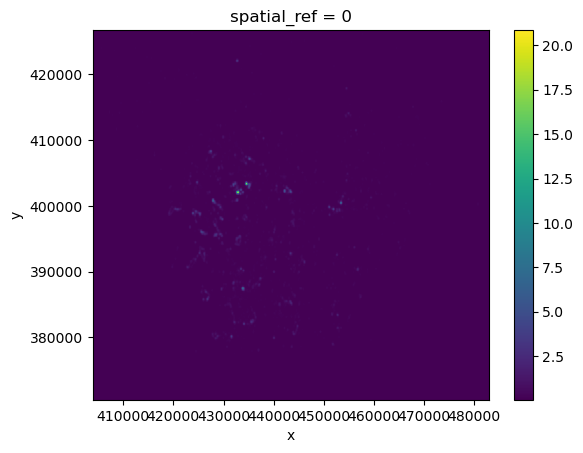

In [32]:
# Convert to xarray
array_x = bin_x[:-1]
array_y = bin_y[:-1]
density_array =  xr.DataArray(
            point_counts, coords={"x":array_x, "y": array_y}
        ).transpose("y", "x")
density_array = density_array.rio.write_crs("EPSG:27700")
density_array = density_array + background_p

density_array.plot()

# Sample Background Points

In [33]:
# Normalise the array
density_array = density_array / density_array.sum()


In [34]:
density_df = density_array.to_dataframe(name="density")
density_df = density_df.reset_index()


density_df.head()

,y,x,spatial_ref,density
0,370543.561784,403914.879459,0,0.000002
1,370543.561784,404014.948163,0,0.000002
2,370543.561784,404115.016866,0,0.000002
3,370543.561784,404215.085570,0,0.000002
4,370543.561784,404315.154273,0,0.000002


In [35]:
# Randomly sample points from the density array based on the density

samples_idx = np.random.choice(density_df.index.values, size=n_background_points, p=density_array.values.flatten())
samples = density_df[["x", "y"]].loc[samples_idx]
# randomly jitter the x and y coordinates by half the resolutions
x_range = (-resolution_x / 2, resolution_x / 2)
y_range = (-resolution_y / 2, resolution_y / 2)
x_noise = np.random.uniform(*x_range, size=n_background_points)
y_noise = np.random.uniform(*y_range, size=n_background_points)
samples["x"] = samples["x"] + x_noise
samples["y"] = samples["y"] + y_noise
samples

,x,y
363752,472223.236418,416517.647907
83313,429711.807426,381022.722090
171177,436034.552275,392150.866622
324861,459022.462122,411539.651942
281490,472438.437287,406093.802378
...,...,...
132655,459780.689537,387220.418854
228080,431131.637508,399328.381891
259689,428047.244871,403330.636645
63677,443656.289635,378599.461252


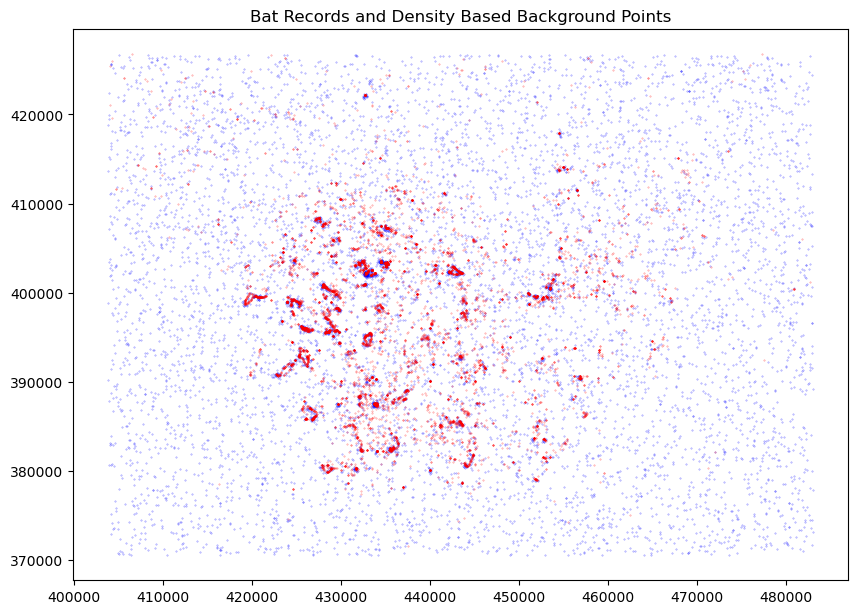

In [37]:
# Convert to  GDF
background_points = gpd.GeoDataFrame(samples, geometry=gpd.points_from_xy(samples.x, samples.y), crs="EPSG:27700")
# Plot the background points and the bat points together, bat points in red, background points in blue
fig, ax = plt.subplots(figsize=(10, 10))
background_points.plot(ax=ax, color="blue", alpha=0.5, markersize=0.1)
bats.plot(ax=ax, color="red", alpha=0.5, markersize=0.1)
# Add title
ax.set_title("Bat Records and Density Based Background Points")
plt.show()

In [39]:
# Write them to a file
background_points.to_parquet("data/processed/background-points.parquet")
# For QGIS
background_points.to_file("data/processed/background-points.geojson", driver="GeoJSON")